Trying to replicate some results from Asllani et. al

In [304]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import solve_ivp, odeint
from scipy.sparse import csgraph
import networkx as nx

#plotting
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

In [305]:
# function to generate a synthetic directed Watts-Strogatz network using the Newman-Watts algorithm
def Newman_Watts_generator(N, K, p):
    #N: number of nodes
    #K: number of nearest neighbours for initial configuration
    #p: probability of rewiring edge
    
    # initial configuration is K-regular ring lattice (on one side only)
    A = np.zeros((N,N))
    start_edges = []

    # for each node n add directed edge going to node n+k for k = 1, ..., K
    for i in range(N):
        for k in range(1,K+1):
            A[i,int((i+k)%N)] = 1
            start_edges.append((i,int((i+k)%10))) # collect list of edges in initial configuration
    
    # re-wiring
    for (i,j) in start_edges:
        r = np.random.rand()
        
        # re-wire edge at probability p
        if r < p:
            
            # possible new destinations for rewired directed edge
            sample = [j1 for j1 in range(N) if j1!=i and (i,j1) not in start_edges]
            newdest = np.random.choice(sample,size=1) # choose at uniform probability
            
            # rewiring
            A[i,j] = 0
            A[i,newdest] = 1
    
    # return resulting adjacency matrix
    return A

In [306]:
# Example with N=10, K=2, p=0.2
N = 10
K = 2
p = 0.2
Newman_Watts_generator(N, K, p)

array([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [356]:
# generate random graph
A = Newman_Watts_generator(100, 10, 0.1)
np.sum(A,axis=0)

array([ 9.,  9.,  9.,  8.,  9., 10.,  9., 10.,  7.,  8., 11., 10., 11.,
       10., 10., 13., 11., 14., 12., 11., 11., 14., 11., 10., 10., 10.,
       12., 10., 11., 11., 13., 14., 11., 12., 10., 13., 11., 12., 11.,
       12., 10., 11., 13., 11., 10., 11., 11., 10., 11., 12., 12., 10.,
       11., 10., 10., 13., 10., 12., 12., 11., 11., 11., 12., 14., 10.,
       10., 10., 12., 10., 11., 10., 11., 10., 11., 10., 11., 10., 11.,
       10., 12., 12., 12., 10., 11., 12., 11., 10., 10., 12., 13., 12.,
       10., 12., 10., 12., 12., 11., 10., 11., 10.])

In [357]:
# function to simulate reaction-diffusion model embedded on a network structure
def simulate_rdm(A, f1, f2, D, init, tspan):
    # A: Adjacency matrix of underlying network (NxN array)
    # f1,f2: nonlinear functions representing reaction terms (functions)
    # D: diffusion coefficients (list of length 2)
    # init: initial conditions
    # tspan: length of time to simulate
    
    # Generate graph Laplacian from adjacency matrix A
    N = len(A)
    Delta = csgraph.laplacian(A, normed=False)

    def system(x,t):
        # 2-species model dependent on functions f1 and f2
        phi = x[:N]
        psi = x[N:]
        
        # Equations
        dphidt = f1(phi,psi) + D[0]*np.matmul(Delta,phi)
        dpsidt = f2(phi,psi) + D[1]*np.matmul(Delta,psi)
        
        # Each row of solutions is first half phi concentration of nodes, second half psi concentration of nodes
        return np.hstack((dphidt, dpsidt))
    
    # Solve
    #sol = solve_ivp(system, tspan, init)
    sol = odeint(system, init, tspan)
    
    # meshgrid of nodes and timescale for plotting
    nodes = np.arange(1,N+1)
    ngrid, tgrid = np.meshgrid(nodes, tspan)
    
    # plotting phi concentrations
    fig = plt.figure(figsize=(10,6))
    c = plt.pcolormesh(ngrid, tgrid, sol[:,:N], cmap=cm.coolwarm)
    cbar = fig.colorbar(c, shrink=0.7, aspect=5)
    plt.clim(0,2)
    plt.xlabel('Node $i$')
    plt.ylabel('time $(s)$')
    plt.title('$\phi_i$ concentration')
    plt.show()
    
    # plotting psi concentrations
    fig = plt.figure(figsize=(10,6))
    c = plt.pcolormesh(ngrid, tgrid, sol[:,N:], cmap=cm.coolwarm)
    cbar = fig.colorbar(c, shrink=0.7, aspect=5)
    plt.clim(0,2)
    plt.xlabel('Node $i$')
    plt.ylabel('time $(s)$')
    plt.title('$\psi_i$ concentration')
    plt.show()

    return sol

In [358]:
# function to simulate reaction-diffusion model embedded on a network structure
def simulate_rdm(A, f1, f2, D, init, tspan):
    # A: Adjacency matrix of underlying network (NxN array)
    # f1,f2: nonlinear functions representing reaction terms (functions)
    # D: diffusion coefficients (list of length 2)
    # init: initial conditions
    # tspan: length of time to simulate
    
    # Generate graph Laplacian from adjacency matrix A
    N = len(A)
    Delta = csgraph.laplacian(A, normed=False)
    
    # setting up system
    sol = init
    phiold = sol[:N]
    psiold = sol[N:]
    dt = tspan[1]

    for t in tspan[:-1]:
        phinew = phiold + dt*(f1(phiold,psiold) + D[0]*np.matmul(Delta,phiold))
        psinew = psiold + dt*(f2(phiold,psiold) + D[1]*np.matmul(Delta,psiold))
        sol = np.vstack(( sol, np.hstack(( phinew, psinew )) ))
        #if t < 5*dt:
        #    print(np.hstack(( phinew, psinew )))
        #    print('\n')
   
    # meshgrid of nodes and timescale for plotting
    nodes = np.arange(1,N+1)
    ngrid, tgrid = np.meshgrid(nodes, tspan)

    # plotting phi concentrations
    fig = plt.figure(figsize=(10,6))
    c = plt.pcolormesh(ngrid, tgrid, sol[:,:N], cmap=cm.coolwarm)
    cbar = fig.colorbar(c, shrink=0.7, aspect=5)
    plt.clim(0,2)
    plt.xlabel('Node $i$')
    plt.ylabel('time $(s)$')
    plt.title('$\phi_i$ concentration')
    plt.show()
    
    # plotting psi concentrations
    fig = plt.figure(figsize=(10,6))
    c = plt.pcolormesh(ngrid, tgrid, sol[:,N:], cmap=cm.coolwarm)
    cbar = fig.colorbar(c, shrink=0.7, aspect=5)
    plt.clim(0,2)
    plt.xlabel('Node $i$')
    plt.ylabel('time $(s)$')
    plt.title('$\psi_i$ concentration')
    plt.show()

    return sol

In [359]:
# Brusselator reaction functions
def f1(x,y):
    global b,c
    return 1 - (b + 1)*x + c*x*x*y

def f2(x,y):
    global b,c
    return b*x - c*x*x*y

In [360]:
G1 = nx.watts_strogatz_graph(100,10,0.1)
adj = nx.adjacency_matrix(G1); adj = adj.toarray()

/tmp/ipykernel_7862/330945389.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G1); adj = adj.toarray()


In [361]:
# Setup
b = 9
c = 30
D = [1, 7]
init = np.ones(2*len(A))
#init = np.hstack(( np.ones(len(A)), b/c*np.ones(len(A)) ))
tspan = np.arange(0,1,0.01)

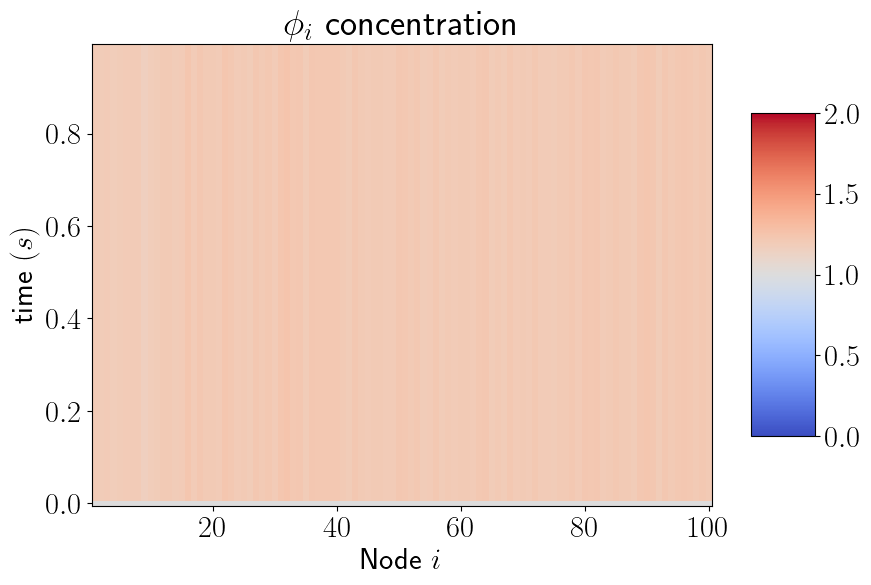

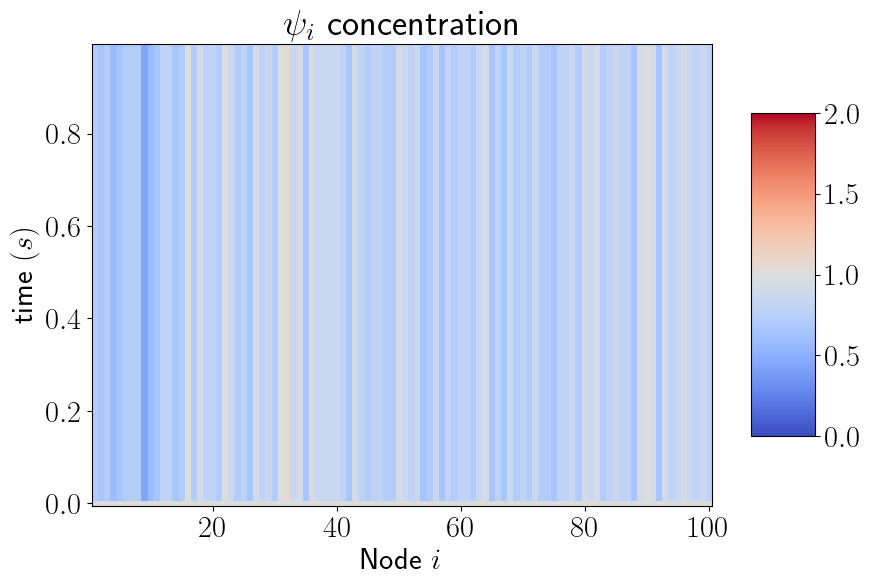

In [362]:
sol = simulate_rdm(A, f1, f2, D, init, tspan)